# MovieLens 100k Collaborative Genre Tagging
**To do**:
  - try out [this implementation](https://www.onceupondata.com/2019/02/10/nn-collaborative-filtering/) of baseline features. 
  - create object classes for models
  - implement TF 2.0 data classes
  - [paperswithcode link](https://paperswithcode.com/sota/collaborative-filtering-on-movielens-100k)
  - [ML 100k state of the art paper](https://arxiv.org/pdf/1706.02263v2.pdf) (RMSE=0.905): details their evaluation method
  
[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/James-Leslie/deep-collaborative-filtering/blob/master/tf-movielens100k.ipynb)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

%matplotlib inline

## Load rating data

In [2]:
# path = 'https://raw.githubusercontent.com/James-Leslie/deep-collaborative-filtering/master/data/ml-100k/'  # access from anywhere
path = 'data/ml-100k/'  # if the files are local
df = pd.read_csv(path+'ratings.csv', usecols=['userId','movieId','rating'])

In [3]:
df.head()

,userId,movieId,rating
0,0,0,3
1,1,1,3
2,2,2,1
3,3,3,2
4,4,4,1


In [4]:
df.shape

(100000, 3)

In [5]:
print('Number of users:', df.userId.nunique())
print('Number of items:', df.movieId.nunique())
print("Min item rating:", df.rating.min())
print("Max item rating:", df.rating.max())
print("Mean item rating:", df.rating.mean())

Number of users: 943
Number of items: 1682
Min item rating: 1
Max item rating: 5
Mean item rating: 3.52986


## Load movie metadata
  - remove 10% as holdout test set

In [6]:
movies = pd.read_csv(path+'movies.csv')
movies.head()

,movieId,title,releaseDate,link,unknown,Action,Adventure,Animation,Children's,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,24,Toy Story (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,147,GoldenEye (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,233,Four Rooms (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,47,Get Shorty (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,75,Copycat (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [7]:
from sklearn.model_selection import train_test_split

In [8]:
movies, movies_holdout = train_test_split(movies, test_size=.1, random_state=42)

---
# Create baseline features
For each user, calculate average user bias - the average difference between the user's rating and the movie's average rating:

$$b_{u} = \dfrac{\sum_{j=1}^{n_u} (r_{uj} - \mu_i)}{n_u}$$

For each item, calculate the difference between its average rating and the average rating of all movies:

$$b_{i} = \dfrac{\sum_{k=1}^{n_i} (r_{ki})}{n_i} - \mu$$

Then, for each interaction, calculate the combined bias:

$$b_{ui} = \dfrac{b_u + b_i}{2}$$

In [9]:
from CGT import get_baseline
?get_baseline

Signature: get_baseline(df, train_index, test_index)
Docstring:
Calculate baseline features from an explicit ratings dataset. Receives a dataframe
and returns train and test splits with added bias column and mean rating value.
User and item biases are calculated as average difference from global mean rating.
Baseline factors are only calculated from training observations, with users or
items that do not appear in train receiving the global average as default.

Args:
    df          : explicit ratings dataframe with columns userId, movieId and rating
    train_index : train index splits taken from KFold.splits()
    test_index  : test index splits taken from KFold.splits()
    
Returns:
    train, test : train/test splits of df, with added bias column
    global_mean : average rating of all training observations
File:      c:\users\jleslie\documents\deep-collaborative-filtering\cgt.py
Type:      function


---
# CGT model
**To do**:
  - Can we avoid re-training rating model on CV fold?
  - Create a grid search function / class

In [10]:
from CGT import compile_genre_model
?compile_genre_model

Signature:
compile_genre_model(
    n_items,
    n_users,
    min_rating,
    max_rating,
    mean_rating,
    n_latent,
    n_hidden_1,
    n_hidden_2,
    activation='relu',
    dropout_1=0.2,
    dropout_2=0.2,
    random_seed=42,
)
Docstring: <no docstring>
File:      c:\users\jleslie\documents\deep-collaborative-filtering\cgt.py
Type:      function


---
## Grid search
**To do**: try using [tqdm](https://github.com/tqdm/tqdm) notebook bars

```bash
# bash
pip install --upgrade ipywidgets 
jupyter nbextension enable --py widgetsnbextension
jupyter labextension install @jupyter-widgets/jupyterlab-manager
```

```python
# python
from tqdm.notebook import trange, tqdm
from time import sleep

for i in trange(3, desc='1st loop'):
    for j in tqdm(range(100), desc='2nd loop'):
        sleep(0.01)
```

## 1. Number of latent factors and hidden nodes

In [11]:
from sklearn.model_selection import KFold

In [12]:
# hyper parameters
HP_N_FACTORS = [50, 100, 200]
HP_N_HIDDEN_1 = [50, 100]
HP_N_HIDDEN_2 = [50, 100]

In [13]:
# dataframe to store results of grid search
grid_results = []
searches = 1

n_models = len(HP_N_FACTORS) * len(HP_N_HIDDEN_1) * len(HP_N_HIDDEN_2)

print(f'Fitting total of {n_models} models\n')

for N_FACTORS in HP_N_FACTORS:
    for N_HIDDEN_1 in HP_N_HIDDEN_1:
        for N_HIDDEN_2 in HP_N_HIDDEN_2:
            
            print(f'Fitting CGT model #{searches} with {N_FACTORS}: {N_HIDDEN_1} | {N_HIDDEN_2} architecture')
            searches += 1
            
            # Create 5 CV folds
            kf = KFold(n_splits=5, random_state=42)
            
            # initialise loss and epoch count
            total_loss = 0
            total_acc = 0
            count = 1
            min_epochs = 10
            
            # do CV split and compute baseline predictors each time
            for train_index, test_index in kf.split(movies):
                
                # get baseline rating predictors for full dataset
                train, _, _ = get_baseline(df, df.index, df.index)

                # compile both models with search hparams
                model1, model2 = compile_genre_model(
                    n_items=df.movieId.nunique(),
                    n_users=df.userId.nunique(),
                    min_rating=df.rating.min(),
                    max_rating=df.rating.max(),
                    mean_rating=df.rating.mean(),
                    n_latent=N_FACTORS, 
                    n_hidden_1=N_HIDDEN_1,
                    n_hidden_2=N_HIDDEN_2
                )

                # train rating model on all data
                ratings = model1.fit(
                    x=[train.userId.values, train.movieId.values, train.bias.values],
                    y=train.rating.values, 
                    batch_size=512,
                    epochs=8,
                    verbose=0,
                    validation_split=.2
                )
                
                # train genre model on 5 CV folds
                train = movies.iloc[train_index]
                test = movies.iloc[test_index]
                
                # train model on current fold
                result = model2.fit(
                    train.movieId.values, train.Drama.values,
                    batch_size=64, 
                    epochs=5,
                    verbose=0,
                    validation_data=(test.movieId.values, test.Drama.values))
                
                # get loss from this fold
                fold_loss = np.sqrt(np.min(result.history['val_loss']))
                total_loss += fold_loss
                fold_acc = np.max(result.history['val_accuracy'])
                total_acc += fold_acc
                min_epochs = min(np.argmin(result.history['val_loss']) + 1, min_epochs)
                
                count += 1
                
                del model1, model2
            
            # calculate average holdout loss across all CV folds
            avg_loss = total_loss / 5
            avg_acc = total_acc / 5
            print(f'_____________________________________CV avg val loss={avg_loss:.4f}')
            print(f'_____________________________________CV avg val acc={avg_acc:.4f}')
            
            grid_results.append({'n_factors':N_FACTORS,
                                 'n_hidden_1':N_HIDDEN_1,
                                 'n_hidden_2':N_HIDDEN_2,
                                 'val_loss':avg_loss,
                                 'val_acc':avg_acc,
                                 'val_epochs':min_epochs,
                                 'train_loss_hist':result.history['loss'],
                                 'val_loss_hist':result.history['val_loss'],
                                 'train_acc_hist':result.history['accuracy'],
                                 'val_acc_hist':result.history['val_accuracy']})
            
            print()
#             break
#         break
#     break
    
col_order = grid_results[0].keys()

# save results to data frame
grid_results = pd.DataFrame(grid_results)
# reorder columns
grid_results = grid_results[col_order]

Fitting total of 12 models

Fitting CGT model #1 with 50: 50 | 50 architecture
_____________________________________CV avg val loss=0.8049
_____________________________________CV avg val acc=0.6200

Fitting CGT model #2 with 50: 50 | 100 architecture
_____________________________________CV avg val loss=0.8002
_____________________________________CV avg val acc=0.6286

Fitting CGT model #3 with 50: 100 | 50 architecture
_____________________________________CV avg val loss=0.8054
_____________________________________CV avg val acc=0.6246

Fitting CGT model #4 with 50: 100 | 100 architecture
_____________________________________CV avg val loss=0.8018
_____________________________________CV avg val acc=0.6200

Fitting CGT model #5 with 100: 50 | 50 architecture
_____________________________________CV avg val loss=0.8025
_____________________________________CV avg val acc=0.6153

Fitting CGT model #6 with 100: 50 | 100 architecture
_____________________________________CV avg val loss=0.7992

In [14]:
# get best 10 models
grid_results = grid_results.sort_values('val_loss')
grid_results.to_csv(path+'grid_results.csv', index=False)

grid_results.head(10)

,n_factors,n_hidden_1,n_hidden_2,val_loss,val_acc,val_epochs,train_loss_hist,val_loss_hist,train_acc_hist,val_acc_hist
11,200,100,100,0.794649,0.638478,2,"[0.6802829359308143, 0.6530684327705156, 0.637...","[0.6551695537093459, 0.625472168654006, 0.6114...","[0.57473165, 0.63996696, 0.6366639, 0.63583815...","[0.6754967, 0.6754967, 0.68543047, 0.6754967, ..."
10,200,100,50,0.795931,0.639790,4,"[0.6851992402364162, 0.663029272826027, 0.6478...","[0.6658622701436478, 0.640324600484987, 0.6230...","[0.5689513, 0.62675476, 0.6300578, 0.63996696,...","[0.6655629, 0.6721854, 0.6655629, 0.6821192, 0..."
7,100,100,100,0.798181,0.630531,3,"[0.683563708816059, 0.6628978004837509, 0.6489...","[0.6647336972470315, 0.6368669212259204, 0.619...","[0.5829893, 0.6218002, 0.62675476, 0.62510324,...","[0.6523179, 0.6490066, 0.65562916, 0.6655629, ..."
9,200,50,100,0.799142,0.635821,2,"[0.6759401847762967, 0.6518791279056464, 0.640...","[0.6496801526341217, 0.6226321340396704, 0.612...","[0.597853, 0.6300578, 0.6391412, 0.6498761, 0....","[0.6456954, 0.6589404, 0.6589404, 0.6589404, 0..."
5,100,50,100,0.799172,0.631200,3,"[0.6782565386112223, 0.6588748087083673, 0.647...","[0.6571874642214238, 0.6327261214224708, 0.619...","[0.58546656, 0.60611063, 0.6110652, 0.6193229,...","[0.63245034, 0.63907284, 0.63907284, 0.6556291..."
8,200,50,50,0.799972,0.632520,3,"[0.6855849563140302, 0.6657034647454908, 0.652...","[0.6668338009853236, 0.6416193815256586, 0.624...","[0.5763832, 0.6234517, 0.62262595, 0.63996696,...","[0.66887414, 0.6423841, 0.6258278, 0.63907284,..."
1,50,50,100,0.800164,0.628569,3,"[0.6798862484149161, 0.6644971878640815, 0.653...","[0.6638481640657842, 0.6431531278502862, 0.628...","[0.60528487, 0.6135425, 0.60115606, 0.61023945...","[0.6490066, 0.6754967, 0.678808, 0.6721854, 0...."
6,100,100,50,0.801328,0.629873,4,"[0.6905550589057456, 0.6736266995933211, 0.660...","[0.6739882041286949, 0.6515323057869412, 0.634...","[0.53096616, 0.59702724, 0.61023945, 0.6135425...","[0.65562916, 0.6589404, 0.65562916, 0.6523179,..."
3,50,100,100,0.801768,0.619957,3,"[0.6859720982272797, 0.6705947490293659, 0.657...","[0.6725915228294221, 0.6510009130105278, 0.634...","[0.57060283, 0.6094137, 0.60115606, 0.61849713...","[0.6125828, 0.6423841, 0.6423841, 0.62913907, ..."
4,100,50,50,0.802526,0.615335,4,"[0.6908773494888986, 0.6746127157049864, 0.662...","[0.6796177913811033, 0.6582052115572999, 0.640...","[0.5251858, 0.6028076, 0.61023945, 0.60776216,...","[0.615894, 0.6125828, 0.6225166, 0.6258278, 0...."


In [15]:
sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (16,9),
            'font.family': 'serif'})

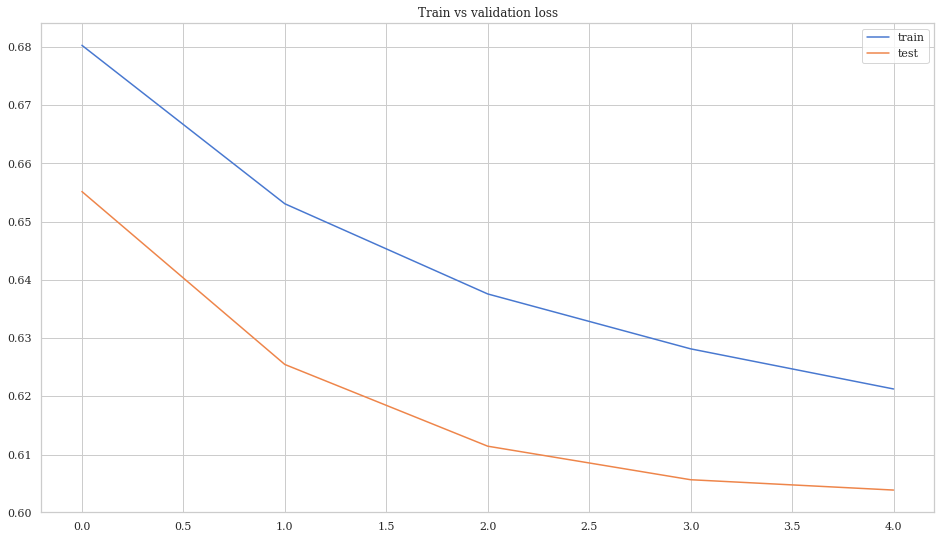

In [16]:
# plot training curve of best model
plt.plot(grid_results.train_loss_hist.values[0], label='train')
plt.plot(grid_results.val_loss_hist.values[0], label='test')
plt.title('Train vs validation loss')
plt.legend()
plt.show()

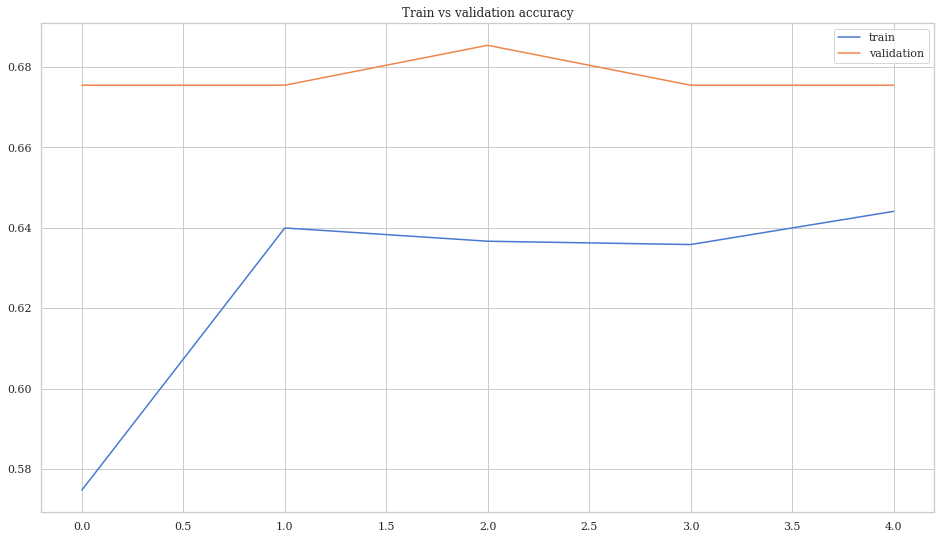

In [17]:
# train vs test accuracy
plt.plot(grid_results.train_acc_hist.values[0], label='train')
plt.plot(grid_results.val_acc_hist.values[0], label='validation')
plt.title('Train vs validation accuracy')
plt.legend()
plt.show()

In [18]:
best_rating_hparams = grid_results.iloc[0,:][['n_factors' ,'n_hidden_1', 'n_hidden_2']]
best_rating_hparams

n_factors     200
n_hidden_1    100
n_hidden_2    100
Name: 11, dtype: object

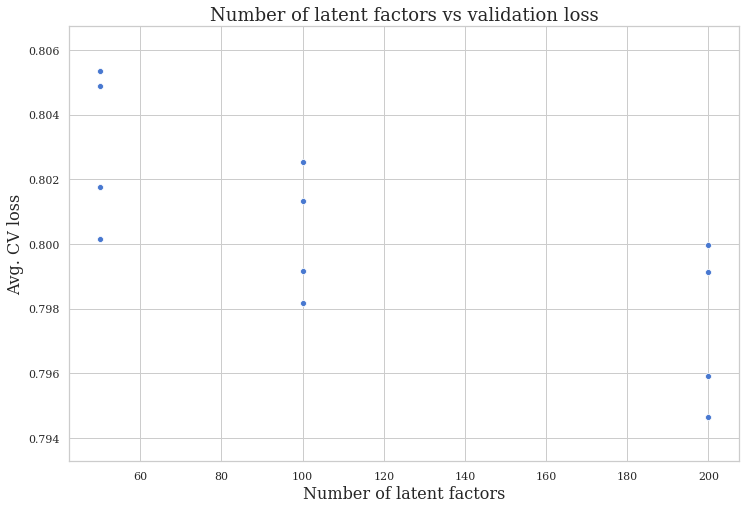

In [19]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='n_factors',
                y='val_loss',
#                 hue='n_hidden_2',
#                 size='n_hidden_2',
#                 palette='Set3',
                data=grid_results)

plt.title('Number of latent factors vs validation loss', fontsize=18)
plt.xlabel('Number of latent factors', fontsize=16)
plt.ylabel('Avg. CV loss', fontsize=16)
plt.savefig('figures/ml_100k_latent_factors.pdf', bbox_inches='tight')
# plt.legend(title='Hidden layer in genre model')
plt.show()

## 2. Dropout rates

In [20]:
# hyper parameters
HP_DROPOUT_1 = [.15, .2, .25]
HP_DROPOUT_2 = [.15, .2, .25]

In [21]:
# dataframe to store results of grid search
grid_results_2 = []
searches = 1

n_models = len(HP_DROPOUT_1) * len(HP_DROPOUT_2)

print(f'Fitting total of {n_models} models\n')

for DROPOUT_1 in HP_DROPOUT_1:
    for DROPOUT_2 in HP_DROPOUT_2:

        print(f'Fitting CGT model #{searches} with dr1: {DROPOUT_1} | dr2: {DROPOUT_2}')
        searches += 1

        # Create 5 CV folds
        kf = KFold(n_splits=5, random_state=42)

        # initialise loss and epoch count
        total_loss = 0
        total_acc = 0
        count = 1
        min_epochs = 10

        # do CV split and compute baseline predictors each time
        for train_index, test_index in kf.split(movies):

            # get baseline rating predictors for full dataset
            train, _, _ = get_baseline(df, df.index, df.index)

            # compile both models with search hparams
            model1, model2 = compile_genre_model(
                n_items=df.movieId.nunique(),
                n_users=df.userId.nunique(),
                min_rating=df.rating.min(),
                max_rating=df.rating.max(),
                mean_rating=df.rating.mean(),
                n_latent=best_rating_hparams.n_factors, 
                n_hidden_1=best_rating_hparams.n_hidden_1,
                n_hidden_2=best_rating_hparams.n_hidden_2,
                dropout_1=DROPOUT_1,
                dropout_2=DROPOUT_2
            )

            # train rating model on all data
            ratings = model1.fit(
                x=[train.userId.values, train.movieId.values, train.bias.values],
                y=train.rating.values, 
                batch_size=512,
                epochs=8,
                verbose=0,
                validation_split=.2
            )

            # train genre model on 5 CV folds
            train = movies.iloc[train_index]
            test = movies.iloc[test_index]

            # train model on current fold
            result = model2.fit(
                train.movieId.values, train.Drama.values,
                batch_size=64, 
                epochs=5,
                verbose=0,
                validation_data=(test.movieId.values, test.Drama.values))

            # get loss from this fold
            fold_loss = np.sqrt(np.min(result.history['val_loss']))
            total_loss += fold_loss
            fold_acc = np.max(result.history['val_accuracy'])
            total_acc += fold_acc
            min_epochs = min(np.argmin(result.history['val_loss']) + 1, min_epochs)

            count += 1

            del model1, model2

        # calculate average holdout loss across all CV folds
        avg_loss = total_loss / 5
        avg_acc = total_acc / 5
        print(f'_____________________________________CV avg val loss={avg_loss:.4f}')
        print(f'_____________________________________CV avg val acc={avg_acc:.4f}')

        grid_results_2.append({'dropout_1':DROPOUT_1,
                               'dropout_2':DROPOUT_2,
                               'val_loss':avg_loss,
                               'val_acc':avg_acc,
                               'val_epochs':min_epochs,
                               'train_loss_hist':result.history['loss'],
                               'val_loss_hist':result.history['val_loss'],
                               'train_acc_hist':result.history['accuracy'],
                               'val_acc_hist':result.history['val_accuracy']})

        print()
#             break
#         break
    
col_order = grid_results_2[0].keys()

# save results to data frame
grid_results_2 = pd.DataFrame(grid_results_2)
# reorder columns
grid_results_2 = grid_results_2[col_order]

Fitting total of 9 models

Fitting CGT model #1 with dr1: 0.15 | dr2: 0.15
_____________________________________CV avg val loss=0.7949
_____________________________________CV avg val acc=0.6424

Fitting CGT model #2 with dr1: 0.15 | dr2: 0.2
_____________________________________CV avg val loss=0.7950
_____________________________________CV avg val acc=0.6424

Fitting CGT model #3 with dr1: 0.15 | dr2: 0.25
_____________________________________CV avg val loss=0.7950
_____________________________________CV avg val acc=0.6418

Fitting CGT model #4 with dr1: 0.2 | dr2: 0.15
_____________________________________CV avg val loss=0.7946
_____________________________________CV avg val acc=0.6378

Fitting CGT model #5 with dr1: 0.2 | dr2: 0.2
_____________________________________CV avg val loss=0.7946
_____________________________________CV avg val acc=0.6385

Fitting CGT model #6 with dr1: 0.2 | dr2: 0.25
_____________________________________CV avg val loss=0.7947
______________________________

In [22]:
# get best 5 models
grid_results_2 = grid_results_2.sort_values('val_loss')
grid_results_2.to_csv(path+'grid_results_2.csv', index=False)

grid_results_2.head(5)

,dropout_1,dropout_2,val_loss,val_acc,val_epochs,train_loss_hist,val_loss_hist,train_acc_hist,val_acc_hist
3,0.20,0.15,0.794552,0.637816,2,"[0.6800321343021881, 0.6526782895099221, 0.637...","[0.6544743203958928, 0.6245149733214979, 0.610...","[0.5829893, 0.6391412, 0.6325351, 0.6391412, 0...","[0.6754967, 0.6821192, 0.6821192, 0.6754967, 0..."
4,0.20,0.20,0.794649,0.638478,2,"[0.6802829359308143, 0.6530684327705156, 0.637...","[0.6551695537093459, 0.625472168654006, 0.6114...","[0.57473165, 0.63996696, 0.6366639, 0.63583815...","[0.6754967, 0.6754967, 0.68543047, 0.6754967, ..."
5,0.20,0.25,0.794715,0.639798,2,"[0.6804109286120074, 0.6533003730482547, 0.637...","[0.6557195727398853, 0.6262470006153283, 0.611...","[0.5821635, 0.6350124, 0.63831544, 0.6366639, ...","[0.6754967, 0.6754967, 0.68543047, 0.678808, 0..."
0,0.15,0.15,0.794889,0.642434,2,"[0.6800118825043853, 0.6523011120068545, 0.636...","[0.6549784138502664, 0.6256898969214484, 0.611...","[0.5871181, 0.6325351, 0.63583815, 0.64492154,...","[0.678808, 0.678808, 0.6655629, 0.66225165, 0...."
1,0.15,0.20,0.794957,0.642439,2,"[0.6800765567432249, 0.6528776392869768, 0.636...","[0.6556361345265875, 0.6265981773666988, 0.612...","[0.5912469, 0.6341866, 0.6350124, 0.6440958, 0...","[0.6754967, 0.68543047, 0.66887414, 0.6589404,..."


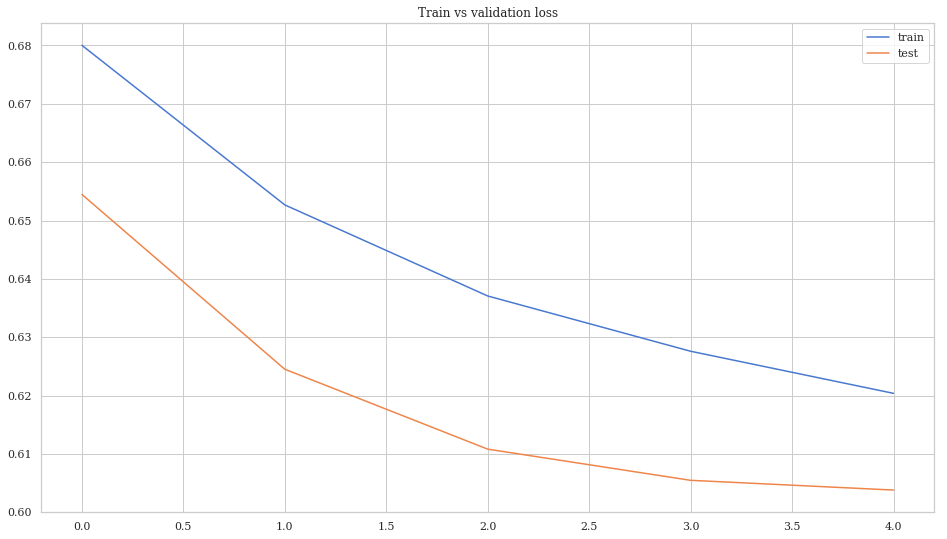

In [23]:
# plot training curve of best model
plt.plot(grid_results_2.train_loss_hist.values[0], label='train')
plt.plot(grid_results_2.val_loss_hist.values[0], label='test')
plt.title('Train vs validation loss')
plt.legend()
plt.show()

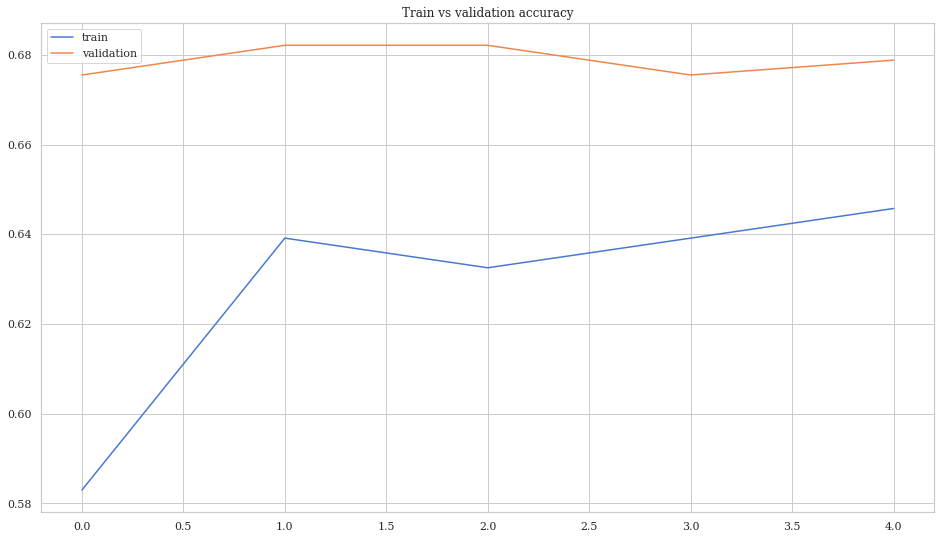

In [24]:
# train vs test accuracy
plt.plot(grid_results_2.train_acc_hist.values[0], label='train')
plt.plot(grid_results_2.val_acc_hist.values[0], label='validation')
plt.title('Train vs validation accuracy')
plt.legend()
plt.show()

In [25]:
best_rating_hparams = pd.concat((best_rating_hparams, grid_results_2.iloc[0,:][['dropout_1', 'dropout_2']]))
best_rating_hparams

n_factors      200
n_hidden_1     100
n_hidden_2     100
dropout_1      0.2
dropout_2     0.15
dtype: object

## 3. Activation function

In [26]:
# hyper parameters
HP_ACTIVATION = [None, 'relu', 'selu', 'softplus', 'tanh']

In [27]:
# dataframe to store results of grid search
grid_results_3 = []
searches = 1

n_models = len(HP_ACTIVATION)

print(f'Fitting total of {n_models} models\n')

for ACTIVATION in HP_ACTIVATION:

    print(f'Fitting CGT model #{searches} with {ACTIVATION}')
    searches += 1

    # Create 5 CV folds
    kf = KFold(n_splits=5, random_state=42)

    # initialise loss and epoch count
    total_loss = 0
    total_acc = 0
    count = 1
    min_epochs = 10

    # do CV split and compute baseline predictors each time
    for train_index, test_index in kf.split(movies):

        # get baseline rating predictors for full dataset
        train, _, _ = get_baseline(df, df.index, df.index)

        # compile both models with search hparams
        model1, model2 = compile_genre_model(
            n_items=df.movieId.nunique(),
            n_users=df.userId.nunique(),
            min_rating=df.rating.min(),
            max_rating=df.rating.max(),
            mean_rating=df.rating.mean(),
            n_latent=best_rating_hparams.n_factors, 
            n_hidden_1=best_rating_hparams.n_hidden_1,
            n_hidden_2=best_rating_hparams.n_hidden_2,
            dropout_1=best_rating_hparams.dropout_1,
            dropout_2=best_rating_hparams.dropout_1,
            activation=ACTIVATION
        )

        # train rating model on all data
        ratings = model1.fit(
            x=[train.userId.values, train.movieId.values, train.bias.values],
            y=train.rating.values, 
            batch_size=512,
            epochs=8,
            verbose=0,
            validation_split=.2
        )

        # train genre model on 5 CV folds
        train = movies.iloc[train_index]
        test = movies.iloc[test_index]

        # train model on current fold
        result = model2.fit(
            train.movieId.values, train.Drama.values,
            batch_size=64, 
            epochs=5,
            verbose=0,
            validation_data=(test.movieId.values, test.Drama.values))

        # get loss from this fold
        fold_loss = np.sqrt(np.min(result.history['val_loss']))
        total_loss += fold_loss
        fold_acc = np.max(result.history['val_accuracy'])
        total_acc += fold_acc
        min_epochs = min(np.argmin(result.history['val_loss']) + 1, min_epochs)

        count += 1

        del model1, model2

    # calculate average holdout loss across all CV folds
    avg_loss = total_loss / 5
    avg_acc = total_acc / 5
    print(f'_____________________________________CV avg val loss={avg_loss:.4f}')
    print(f'_____________________________________CV avg val acc={avg_acc:.4f}')

    grid_results_3.append({'activation':ACTIVATION,
                           'val_loss':avg_loss,
                           'val_acc':avg_acc,
                           'val_epochs':min_epochs,
                           'train_loss_hist':result.history['loss'],
                           'val_loss_hist':result.history['val_loss'],
                           'train_acc_hist':result.history['accuracy'],
                           'val_acc_hist':result.history['val_accuracy']})

    print()
    
col_order = grid_results_3[0].keys()

# save results to data frame
grid_results_3 = pd.DataFrame(grid_results_3)
# reorder columns
grid_results_3 = grid_results_3[col_order]

Fitting total of 5 models

Fitting CGT model #1 with None
_____________________________________CV avg val loss=0.8050
_____________________________________CV avg val acc=0.6114

Fitting CGT model #2 with relu
_____________________________________CV avg val loss=0.7946
_____________________________________CV avg val acc=0.6385

Fitting CGT model #3 with selu
_____________________________________CV avg val loss=0.8037
_____________________________________CV avg val acc=0.6160

Fitting CGT model #4 with softplus
_____________________________________CV avg val loss=0.8024
_____________________________________CV avg val acc=0.6180

Fitting CGT model #5 with tanh
_____________________________________CV avg val loss=0.8042
_____________________________________CV avg val acc=0.6100



In [37]:
# get best 5 models
grid_results_3 = grid_results_3.sort_values('val_loss')
grid_results_3.to_csv(path+'grid_results_3.csv', index=False)

grid_results_3.head(5)

,activation,val_loss,val_acc,val_epochs,train_loss_hist,val_loss_hist,train_acc_hist,val_acc_hist
1,relu,0.794649,0.638478,2,"[0.6802829359308143, 0.6530684327705156, 0.637...","[0.6551695537093459, 0.625472168654006, 0.6114...","[0.57473165, 0.63996696, 0.6366639, 0.63583815...","[0.6754967, 0.6754967, 0.68543047, 0.6754967, ..."
3,softplus,0.802429,0.617981,1,"[0.6883237631137857, 0.6891428355241392, 0.674...","[0.6255033260939137, 0.6121826969235149, 0.610...","[0.5631709, 0.59454995, 0.580512, 0.6019818, 0...","[0.615894, 0.65562916, 0.6490066, 0.6423841, 0..."
2,selu,0.803681,0.615997,1,"[0.6624800185346091, 0.6482735846182416, 0.644...","[0.613123385322015, 0.6122547652547723, 0.6160...","[0.59207267, 0.59867877, 0.6135425, 0.6135425,...","[0.6456954, 0.6523179, 0.6490066, 0.66225165, ..."
4,tanh,0.804216,0.610041,1,"[0.6643886292502469, 0.6522306608425301, 0.650...","[0.6158740331005577, 0.6125395479581214, 0.616...","[0.6044591, 0.6019818, 0.60115606, 0.60528487,...","[0.6423841, 0.63907284, 0.63245034, 0.63907284..."
0,None,0.805008,0.611365,1,"[0.6653364096467501, 0.6530428231992965, 0.650...","[0.6166175284133052, 0.613664441945537, 0.6185...","[0.5928984, 0.6028076, 0.6085879, 0.6094137, 0...","[0.63245034, 0.6423841, 0.62913907, 0.6258278,..."


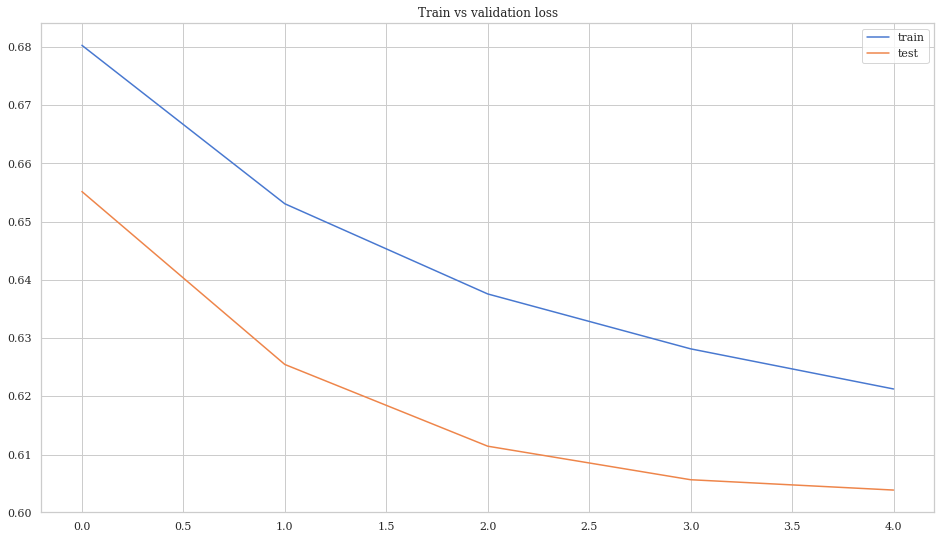

In [38]:
# plot training curve of best model
plt.plot(grid_results_3.train_loss_hist.values[0], label='train')
plt.plot(grid_results_3.val_loss_hist.values[0], label='test')
plt.title('Train vs validation loss')
plt.legend()
plt.show()

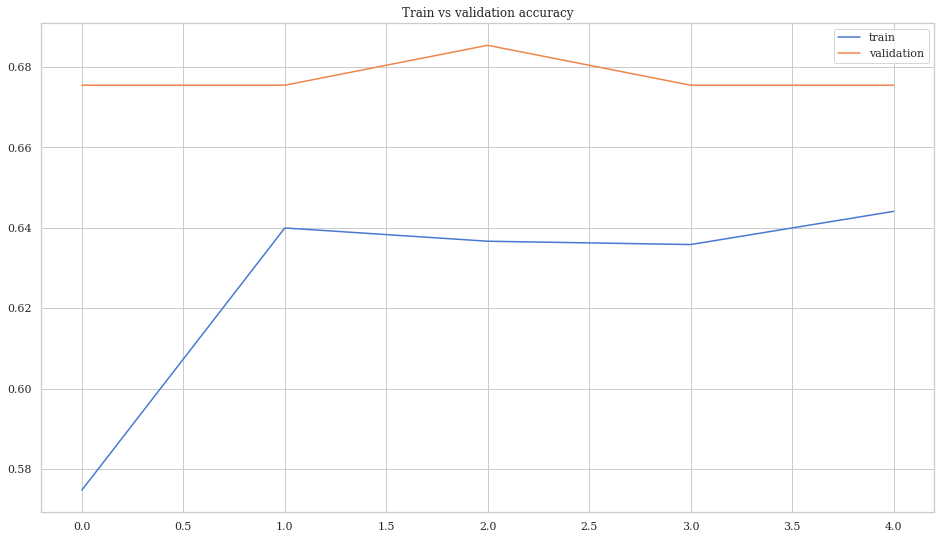

In [39]:
# train vs test accuracy
plt.plot(grid_results_3.train_acc_hist.values[0], label='train')
plt.plot(grid_results_3.val_acc_hist.values[0], label='validation')
plt.title('Train vs validation accuracy')
plt.legend()
plt.show()

In [40]:
best_rating_hparams = pd.concat((best_rating_hparams, grid_results_3.iloc[0,:][['activation']]))
best_rating_hparams

n_factors      200
n_hidden_1     100
n_hidden_2     100
dropout_1      0.2
dropout_2     0.15
activation    relu
activation    relu
dtype: object

# Classification report

In [32]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

### Re-train model on full dataset, with best hparams

In [33]:
# get baseline predictors for full dataset
train, _, _ = get_baseline(df, df.index, df.index)

# compile both models
model1, model2 = compile_genre_model(
    n_items=df.movieId.nunique(),
    n_users=df.userId.nunique(),
    min_rating=df.rating.min(),
    max_rating=df.rating.max(),
    mean_rating=df.rating.mean(),
    n_latent=best_rating_hparams.n_factors, 
    n_hidden_1=best_rating_hparams.n_hidden_1,
    n_hidden_2=best_rating_hparams.n_hidden_2,
    dropout_1=best_rating_hparams.dropout_1,
    dropout_2=best_rating_hparams.dropout_1,
    activation=best_rating_hparams.activation
)

# train rating model
ratings = model1.fit(
    x=[train.userId.values, train.movieId.values, train.bias.values],
    y=train.rating.values, 
    batch_size=256,
    epochs=8,
    verbose=1,
    validation_split=.2
)

# train genre model
genres = model2.fit(
    movies.movieId.values, movies.Drama.values,
    batch_size=64, 
    epochs=5,
    validation_split=.2)

Train on 80000 samples, validate on 20000 samples
Epoch 1/8
80000/80000 [==============================] - 4s 51us/sample - loss: 0.8926 - val_loss: 0.8583
Epoch 2/8
80000/80000 [==============================] - 4s 46us/sample - loss: 0.8358 - val_loss: 0.8452
Epoch 3/8
80000/80000 [==============================] - 4s 46us/sample - loss: 0.8013 - val_loss: 0.8360
Epoch 4/8
80000/80000 [==============================] - 4s 45us/sample - loss: 0.7586 - val_loss: 0.8353
Epoch 5/8
80000/80000 [==============================] - 4s 45us/sample - loss: 0.7107 - val_loss: 0.8392
Epoch 6/8
80000/80000 [==============================] - 4s 45us/sample - loss: 0.6631 - val_loss: 0.8555
Epoch 7/8
80000/80000 [==============================] - 4s 45us/sample - loss: 0.6171 - val_loss: 0.8759
Epoch 8/8
80000/80000 [==============================] - 4s 45us/sample - loss: 0.5784 - val_loss: 0.8840
Train on 1210 samples, validate on 303 samples
Epoch 1/5
1210/1210 [==============================] - 

### Evaluate on test set

In [34]:
X_test = movies_holdout.movieId.values
y_test = movies_holdout.Drama.values
y_score = pd.DataFrame(model2.predict(X_test))
y_pred = y_score.round().astype('int')

In [35]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.65      0.63        96
           1       0.51      0.48      0.49        73

    accuracy                           0.57       169
   macro avg       0.56      0.56      0.56       169
weighted avg       0.57      0.57      0.57       169



In [36]:
pd.DataFrame(confusion_matrix(y_test, y_pred))

,0,1
0,62,34
1,38,35


---
# Appendix A: Ratings model

## Define architecture

In [7]:
def compile_model(n_users, n_items, mean_rating, n_factors=25, n_hidden=64, leaky_alpha=.1, dropout=.2):
    
    # item latent factors
    item_in = Input(shape=[1])  # name='item'
    item_em = Embedding(n_items, n_factors)(item_in)
    item_vec = Flatten()(item_em)
    
    # user latent factors
    user_in = Input(shape=[1])
    user_em = Embedding(n_users, n_factors)(user_in)
    user_vec = Flatten()(user_em)
    
    # user x item bias
    bias = Input(shape=[1])
    
    # if there is a hidden layer
    if n_hidden:
        # concatenate user and item vectors
        conc = Concatenate()([item_vec, user_vec])
        # hidden layer
        hidden = Dense(n_hidden)(conc)
        leaky = LeakyReLU(alpha=leaky_alpha)(hidden)
        drop = Dropout(dropout)(leaky)
        
        out = Dense(1)(drop)
        
    # if there are no hidden layers
    else:
        out = Dot(name="Dot-Product", axes=1)([item_vec, user_vec])
    
    rating = tf.math.add(Add()([out, bias]), mean_rating)
    
    # create model and compile it
    model = Model([user_in, item_in, bias], rating)
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

## Grid search
### Best CV score: 0.920123 (20 : 40 : 0.2)

In [8]:
# hyper parameters
HP_N_FACTORS = [8, 32, 64, 128]
HP_N_HIDDEN = [0, 16, 32, 64]
HP_DROPOUT = [0, .2, .25]

In [9]:
# dataframe to store results of grid search
grid_results = []
best_loss = 1
searches = 1

n_models = len(HP_N_FACTORS) * len(HP_N_HIDDEN) * len(HP_DROPOUT)

print(f'Fitting total of {n_models} models\n')

for N_FACTORS in HP_N_FACTORS:
    for N_HIDDEN in HP_N_HIDDEN:
        for DROPOUT in HP_DROPOUT:
            
            print(f'Fitting model #{searches} with {N_FACTORS}: {N_HIDDEN} architecture, {DROPOUT} dropout rate')
            searches += 1
            
            # Create 5 CV folds
            kf = KFold(n_splits=5, random_state=42)
            
            # initialise loss and epoch count
            total_loss, count = 0, 1
            min_epochs = 10
            
            # do CV split and compute baseline predictors each time
            for train_index, test_index in kf.split(df):
                train, test, global_mean = get_baseline(df, train_index, test_index)
                
                # compile model with chosen h-params
                model = compile_model(
                    n_users = df.userId.nunique(),
                    n_items = df.movieId.nunique(),
                    mean_rating = global_mean,
                    n_factors = N_FACTORS,
                    n_hidden = N_HIDDEN,
                    dropout = DROPOUT
                )
                
                # train model on CV fold
                result = model.fit(x=[train.userId.values, train.movieId.values, train.bias.values],
                                   y=train.rating.values, 
                                   batch_size=512,
                                   epochs=10,
                                   verbose=0,
                                   validation_data=([test.userId.values, test.movieId.values, test.bias.values], test.rating.values))
                
                # get loss from this fold
                fold_loss = np.sqrt(np.min(result.history['val_loss']))
                total_loss += fold_loss
                min_epochs = min(np.argmin(result.history['val_loss']) + 1, min_epochs)
                
#                 print(f'CV split #{count}: RMSE={fold_loss:.4f}')
                count += 1
            
            # calculate average holdout loss across all CV folds
            avg_loss = total_loss / 5
            best_loss = min(avg_loss, best_loss)
            print(f'_____________________________________CV avg RMSE={avg_loss:.4f}')
            
#             plt.plot(result.history['loss'], label='train')
#             plt.plot(result.history['val_loss'], label='val')
#             plt.axhline(y=best_loss, color='r', lw=1, ls='-')
#             plt.legend()
#             plt.show()
            
            grid_results.append({'n_factors':N_FACTORS,
                                 'n_hidden':N_HIDDEN,
                                 'dropout':DROPOUT,
                                 'val_rmse':avg_loss,
                                 'val_epochs':min_epochs,
                                 'train_hist':result.history['loss'],
                                 'val_hist':result.history['val_loss']})
            print()
            break
        break
#     break

# save results to data frame
grid_results = pd.DataFrame(data=grid_results, columns=grid_results[0].keys())

Fitting total of 48 models

Fitting model #1 with 8: 0 architecture, 0 dropout rate
_____________________________________CV avg RMSE=0.9457

Fitting model #2 with 32: 0 architecture, 0 dropout rate
_____________________________________CV avg RMSE=0.9344

Fitting model #3 with 64: 0 architecture, 0 dropout rate
_____________________________________CV avg RMSE=0.9312

Fitting model #4 with 128: 0 architecture, 0 dropout rate
_____________________________________CV avg RMSE=0.9294



In [10]:
# get best 10 models
grid_results = grid_results.sort_values('val_rmse')
grid_results.head(10)

,n_factors,n_hidden,dropout,val_rmse,val_epochs,train_hist,val_hist
3,128,0,0,0.929420,6,"[0.9448764749526978, 0.9171774558067322, 0.841...","[0.967871939086914, 0.9573996433258056, 0.9177..."
2,64,0,0,0.931192,7,"[0.9447980142593384, 0.9308741952896118, 0.890...","[0.9683909816741944, 0.9633234424591064, 0.938..."
1,32,0,0,0.934400,8,"[0.9448338025093078, 0.937631623840332, 0.9148...","[0.9684047742843628, 0.9652086585998535, 0.948..."
0,8,0,0,0.945660,10,"[0.9448830952644348, 0.9432240547180176, 0.938...","[0.9686725238800049, 0.9682414264678955, 0.965..."


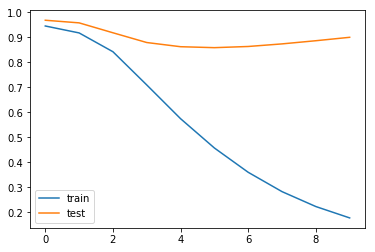

In [11]:
# plot training curve of best model
plt.plot(grid_results.iloc[0,-2], label='train')
plt.plot(grid_results.iloc[0,-1], label='test')
plt.legend()
plt.show()

In [12]:
best_rating_hparams = grid_results.iloc[0,:][['n_factors' ,'n_hidden', 'dropout']]
best_rating_hparams

n_factors    128
n_hidden       0
dropout        0
Name: 3, dtype: object

---
# Appendix B: multi-label genre model

In [ ]:
def compile_genre_model(n_items, n_users, mean_rating, n_genres, n_latent, n_hidden_1, n_hidden_2, dropout_1, dropout_2):
    
    # item latent factors
    item_in = Input(shape=[1])  # name='item'
    item_em = Embedding(n_items, n_latent)(item_in)
    item_vec = Flatten()(item_em)
    
    # user latent factors
    user_in = Input(shape=[1])
    user_em = Embedding(n_users, n_latent)(user_in)
    user_vec = Flatten()(user_em)
    
    # user x item bias
    bias = Input(shape=[1])
    
    # concatenate user and item vectors
    conc = Concatenate()([item_vec, user_vec])
    # hidden layer
    hidden_1 = Dense(n_hidden_1)(conc)
    leaky = LeakyReLU(alpha=0.1)(hidden_1)
    drop_1 = Dropout(dropout_1)(leaky)
    
    out = Dense(1)(drop_1)
            
    rating = tf.math.add(Add()([out, bias]), mean_rating)
    
    # create model and compile it
    model = Model([user_in, item_in, bias], rating)
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # model 2
    hidden_2 = Dense(n_hidden_2, activation='relu')(item_vec)
    drop_2 = Dropout(dropout_2)(hidden_2)
    genre = Dense(n_genres, activation='sigmoid')(drop_2)  # there are 18 genres

    # Create model and compile it
    model2 = Model(item_in, genre)
    # freeze the embedding layer
    model2.layers[1].trainable = False
    model2.compile(optimizer='adam', loss='binary_crossentropy' , metrics=['accuracy', 'AUC'])
    
    return model, model2

In [15]:
# get baseline predictors for full dataset
train, _, _ = get_baseline(df, df.index, df.index)

# compile both models
model1, model2 = compile_genre_model(
    n_items = df.movieId.nunique(),
    n_users = df.userId.nunique(),
    mean_rating = df.rating.mean(), 
    n_genres=18,
    n_latent=best_rating_hparams.n_factors, 
    n_hidden_1=best_rating_hparams.n_hidden,
    n_hidden_2=64,
    dropout_1=best_rating_hparams.dropout,
    dropout_2=.2
)

# train rating model
ratings = model1.fit(
    x=[train.userId.values, train.movieId.values, train.bias.values],
    y=train.rating.values, 
    batch_size=256,
    epochs=10,
    verbose=1,
    validation_split=.2
)

Train on 80000 samples, validate on 20000 samples
Epoch 1/10
80000/80000 [==============================] - 1s 18us/sample - loss: 0.9487 - val_loss: 0.9348
Epoch 2/10
80000/80000 [==============================] - 1s 12us/sample - loss: 0.9487 - val_loss: 0.9348
Epoch 3/10
80000/80000 [==============================] - 1s 12us/sample - loss: 0.9487 - val_loss: 0.9348
Epoch 4/10
80000/80000 [==============================] - 1s 13us/sample - loss: 0.9487 - val_loss: 0.9348
Epoch 5/10
80000/80000 [==============================] - 1s 13us/sample - loss: 0.9487 - val_loss: 0.9348
Epoch 6/10
80000/80000 [==============================] - 1s 14us/sample - loss: 0.9487 - val_loss: 0.9348
Epoch 7/10
80000/80000 [==============================] - 1s 12us/sample - loss: 0.9487 - val_loss: 0.9348
Epoch 8/10
80000/80000 [==============================] - 1s 12us/sample - loss: 0.9487 - val_loss: 0.9348
Epoch 9/10
80000/80000 [==============================] - 1s 12us/sample - loss: 0.9487 - val_

In [16]:
# train genre model
genres = model2.fit(
#     movies.movieId.values, movies.Drama.values,  # drama only
    movies.movieId.values, movies.iloc[:,-18:].values,  # multi label
    batch_size=64, 
    epochs=5,
    validation_split=.2)

Train on 1345 samples, validate on 337 samples
Epoch 1/5
1345/1345 [==============================] - 0s 367us/sample - loss: 0.6794 - accuracy: 0.7493 - val_loss: 0.6625 - val_accuracy: 0.9054
Epoch 2/5
1345/1345 [==============================] - 0s 38us/sample - loss: 0.6466 - accuracy: 0.8887 - val_loss: 0.6172 - val_accuracy: 0.9228
Epoch 3/5
1345/1345 [==============================] - 0s 37us/sample - loss: 0.5925 - accuracy: 0.8994 - val_loss: 0.5452 - val_accuracy: 0.9232
Epoch 4/5
1345/1345 [==============================] - 0s 41us/sample - loss: 0.5168 - accuracy: 0.8998 - val_loss: 0.4540 - val_accuracy: 0.9232
Epoch 5/5
1345/1345 [==============================] - 0s 39us/sample - loss: 0.4349 - accuracy: 0.8998 - val_loss: 0.3683 - val_accuracy: 0.9232


In [17]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

In [18]:
y_true = movies.iloc[:,-18:]
y_score = pd.DataFrame(model2.predict(movies.movieId.values), columns=y_true.columns)
y_pred = y_score.round().astype('int')

In [19]:
drama_true = y_true.Drama
drama_pred = y_pred.Drama

In [20]:
print(classification_report(drama_true, drama_pred))

              precision    recall  f1-score   support

           0       0.57      1.00      0.73       957
           1       0.00      0.00      0.00       725

    accuracy                           0.57      1682
   macro avg       0.28      0.50      0.36      1682
weighted avg       0.32      0.57      0.41      1682



C:\Users\JLeslie\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\JLeslie\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\JLeslie\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [21]:
pd.DataFrame(confusion_matrix(drama_true, drama_pred))

,0,1
0,957,0
1,725,0


In [22]:
print(classification_report(y_true, y_pred, target_names=y_true.columns))

              precision    recall  f1-score   support

      Action       0.00      0.00      0.00       251
   Adventure       0.00      0.00      0.00       135
   Animation       0.00      0.00      0.00        42
  Children's       0.00      0.00      0.00       122
      Comedy       0.00      0.00      0.00       505
       Crime       0.00      0.00      0.00       109
 Documentary       0.00      0.00      0.00        50
       Drama       0.00      0.00      0.00       725
     Fantasy       0.00      0.00      0.00        22
   Film-Noir       0.00      0.00      0.00        24
      Horror       0.00      0.00      0.00        92
     Musical       0.00      0.00      0.00        56
     Mystery       0.00      0.00      0.00        61
     Romance       0.00      0.00      0.00       247
      Sci-Fi       0.00      0.00      0.00       101
    Thriller       0.00      0.00      0.00       251
         War       0.00      0.00      0.00        71
     Western       0.00    

C:\Users\JLeslie\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\JLeslie\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\JLeslie\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\JLeslie\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being